### Projecto de Machine Learning - Etapa 1
Autor: German Andres Torres

#### 1) Carga y visualización de los datos

Como primer paso, importaremos todas las librerías necesarias.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score,root_mean_squared_error
from sklearn.pipeline import make_pipeline

Hacemos la carga del archivo de datos.

In [5]:
route = './data/Datos_Etapa-1.csv'
data_raw = pd.read_csv(route, sep=',')
data_raw.shape

(17379, 9)

Se cuentan con 17379 registros y 9 columnas. A continuación, se realiza una breve revisión de los datos generales y se observan algunos registros.

In [7]:
data_raw.describe()

,weekday,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,3.003683,15.358397,15.401157,0.627229,12.736540,189.463088
std,2.005771,9.050138,11.342114,0.192930,8.196795,181.387599
min,0.000000,-7.060000,-16.000000,0.000000,0.000000,1.000000
25%,1.000000,7.980000,5.997800,0.480000,7.001500,40.000000
50%,3.000000,15.500000,15.996800,0.630000,12.998000,142.000000
75%,5.000000,23.020000,24.999200,0.780000,16.997900,281.000000
max,6.000000,39.000000,50.000000,1.000000,56.996900,977.000000


In [8]:
data_raw.head()

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.28,3.0014,0.81,0.0,16,Night
1,Winter,6,Clear,2.34,1.9982,0.80,0.0,40,Night
2,Winter,6,Clear,2.34,1.9982,0.80,0.0,32,Night
3,Winter,6,Clear,3.28,3.0014,0.75,0.0,13,Night
4,Winter,6,Clear,3.28,3.0014,0.75,0.0,1,Night


Se genera una copia del DataFrame para evitar afectar los registros originales y poder manipular la información sin riesgos.

In [10]:
data = data_raw.copy()

#### 2) Visualización de Información

En los siguientes gráficos, podemos observar que el uso de bicicletas está muy relacionado con el aumento de la temperatura. Este comportamiento se puede evidenciar en todas las estaciones.

1. **Cantidad de Bicicletas vs Temperatura**

   En los gráficos siguientes, se observa una clara relación entre el uso de bicicletas y el aumento de la temperatura. Este patrón es consistente en todas las estaciones del año.

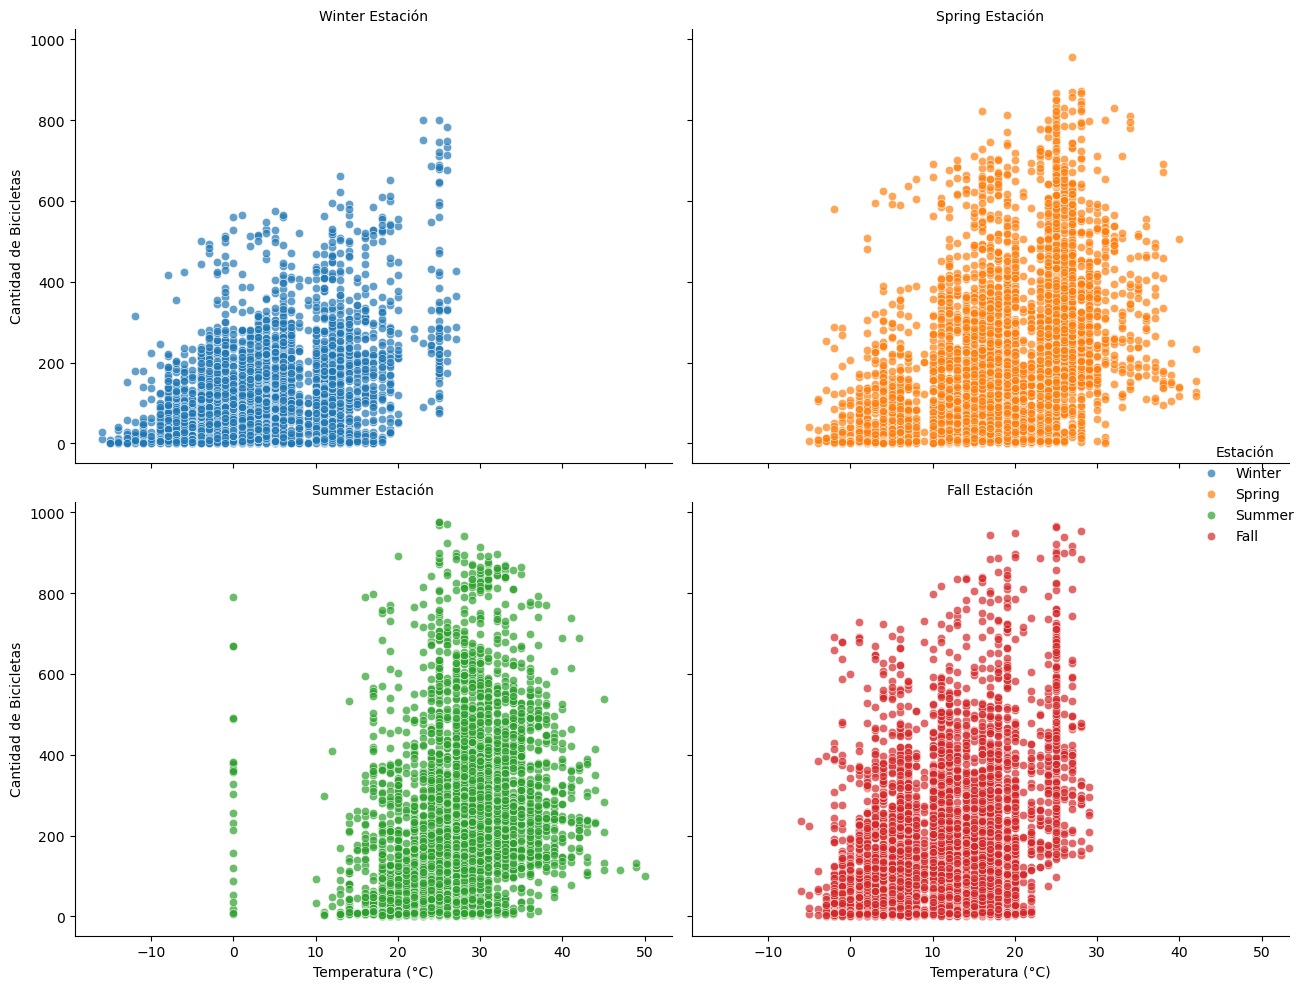

In [12]:
g1 = sns.FacetGrid(data, col='season', hue='season', col_wrap=2, height=5, aspect=1.2)
g1.map(sns.scatterplot, 'atemp', 'cnt', alpha=0.7)
g1.set_axis_labels('Temperatura (°C)', 'Cantidad de Bicicletas')
g1.set_titles(col_template="{col_name} Estación")
g1.add_legend(title='Estación')
plt.tight_layout()
plt.show()


2. **Cantidad de Bicicletas vs Parte del día**
   
   En el siguiente gráfico, se puede apreciar cómo la cantidad de bicicletas alquiladas varía según la parte del día.

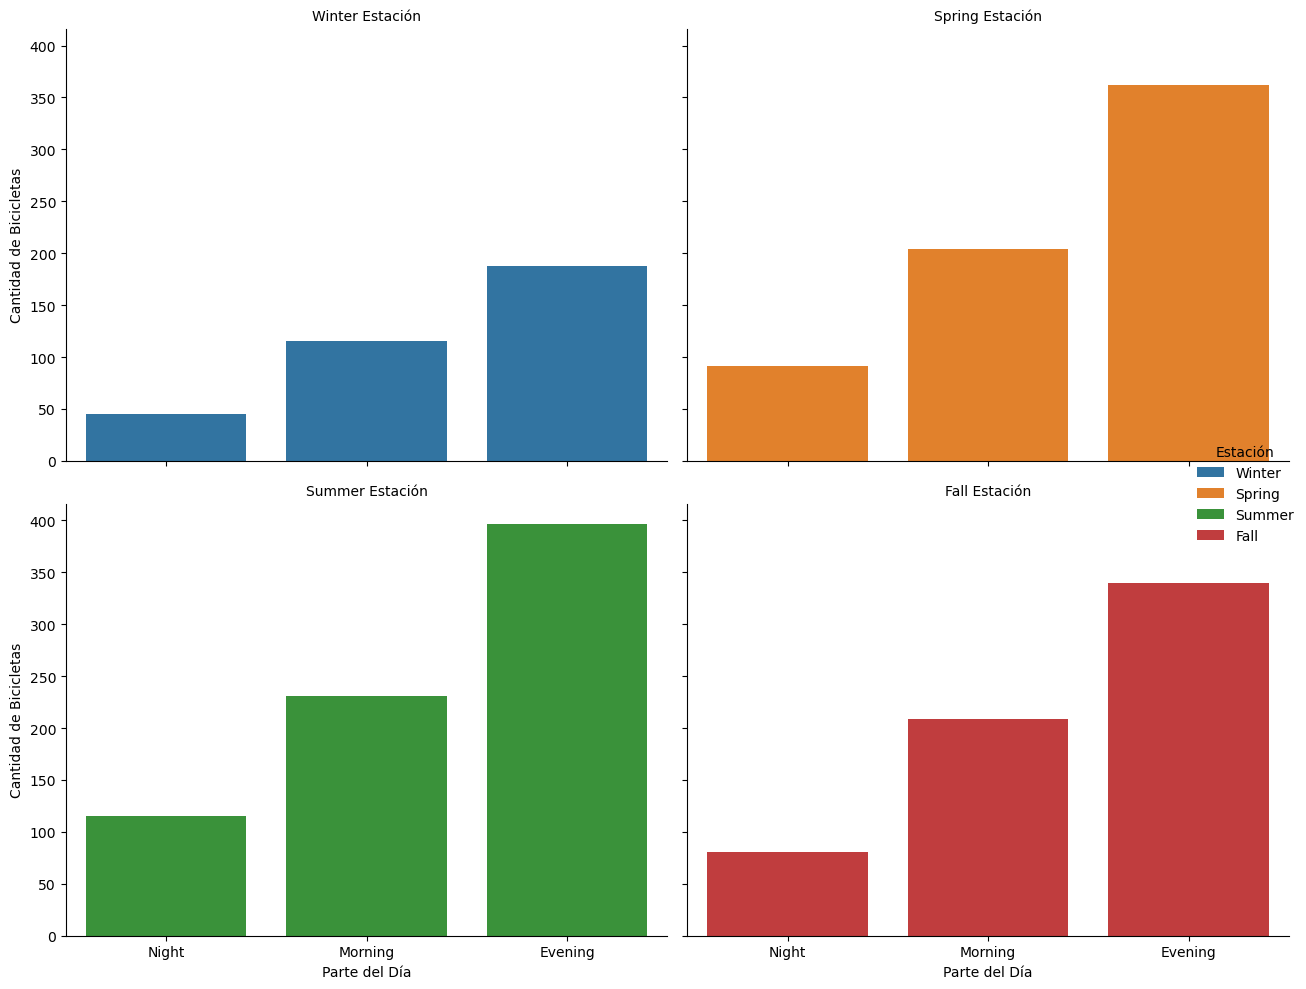

In [14]:
g2 = sns.FacetGrid(data, col='season', hue='season', col_wrap=2, height=5, aspect=1.2)
g2.map_dataframe(sns.barplot, x='time_of_day', y='cnt', errorbar=None)
g2.set_axis_labels('Parte del Día', 'Cantidad de Bicicletas')
g2.set_titles(col_template="{col_name} Estación")
g2.add_legend(title='Estación', label_order=data['season'].unique())
plt.tight_layout()
plt.show()


3. **Cantidad de Bicicletas vs Día de la Semana**
   
   En este caso, se observa un uso constante y relativamente estable de bicicletas durante la primavera, el verano y el otoño. En contraste, durante el invierno se nota una disminución en el uso, lo cual es esperable debido a las condiciones climáticas que pueden limitar el uso de bicicletas. Esto plantea dudas sobre la relevancia de esta variable para el proyecto.

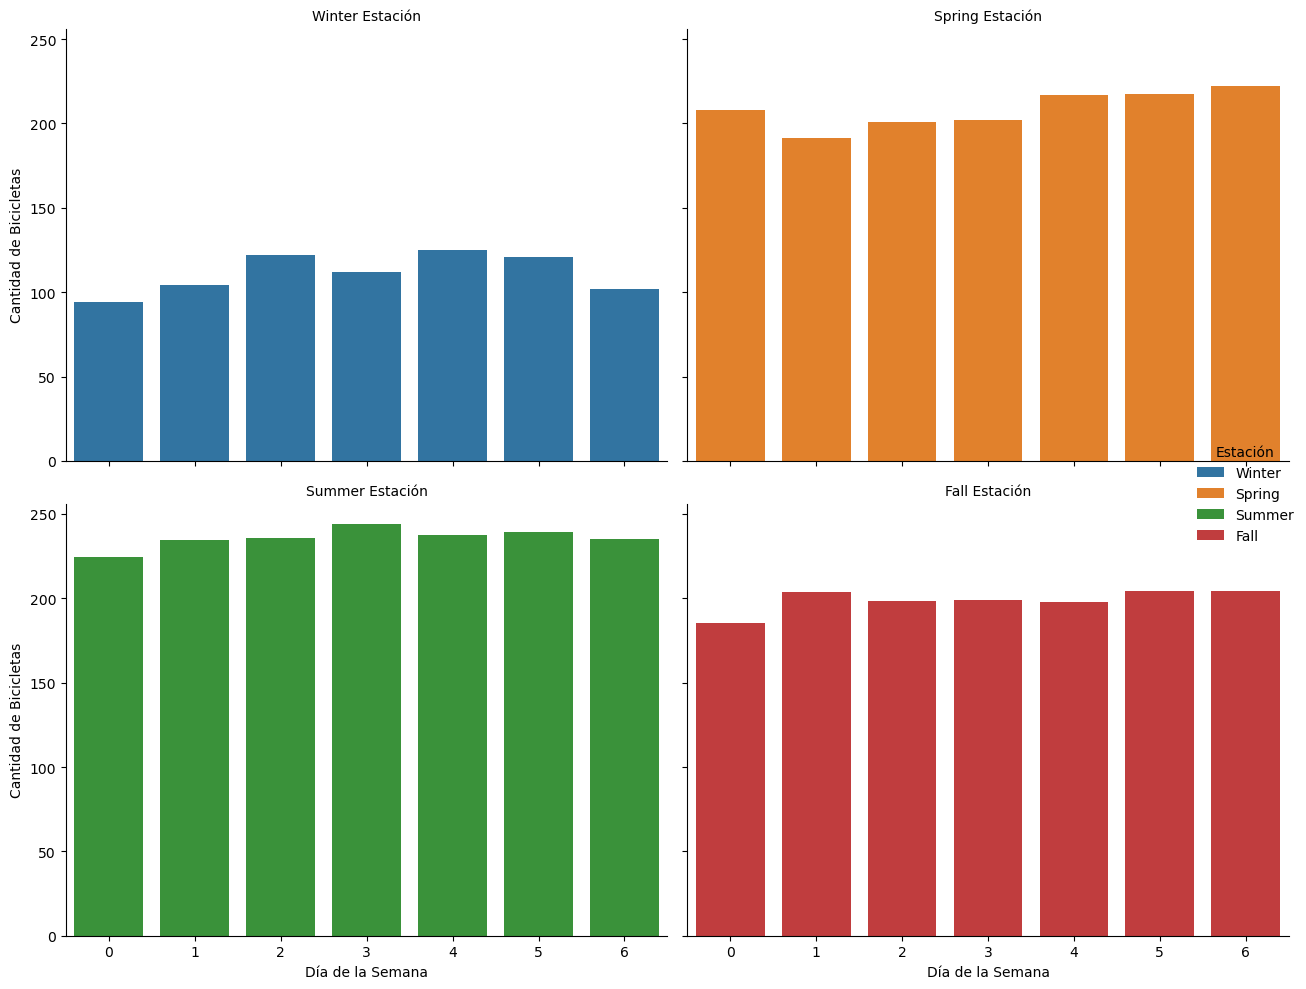

In [16]:
g3 = sns.FacetGrid(data, col='season',hue='season', col_wrap=2, height=5, aspect=1.2)
g3.map_dataframe(sns.barplot, x='weekday', y='cnt', errorbar=None)
g3.set_axis_labels('Día de la Semana', 'Cantidad de Bicicletas')
g3.set_titles(col_template="{col_name} Estación")
g3.add_legend(title='Estación', label_order=data['season'].unique())
plt.tight_layout()
plt.show()

#### 3) Preparación y limpieza de los datos

**NOTA:** Un dato importante a resaltar en este ejercicio es que no se eliminarán columnas inicialmente, ya que más adelante se aplicará un modelo Lasso para determinar cuáles variables tienen relación con nuestra variable objetivo.

Como primer paso, se revisa si hay datos nulos.

In [18]:
data.isna().sum()

season         0
weekday        0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
cnt            0
time_of_day    0
dtype: int64

En este caso no tenemos presencia de nulos en nuestro dataset. Seguimos con la evaluación duplicados.

In [20]:
data.duplicated().sum()

42

Nos encontramos con 42 duplicados los cuales pueden afectar a nuestro modelo por lo que se eliminan estos regitros

In [22]:
data = data.drop_duplicates()

Realizamos una rapida comprobación.

Inicialmente teniamos **17379** donde **42** son duplicados, por lo que nos deberian quedar **17337** 

In [24]:
data.shape

(17337, 9)

Ahora, otro paso importante en la preparación de los datos es validar que los valores se encuentren dentro de los definidos en el diccionario. Esto permite identificar posibles anomalías en el conjunto de datos.

**NOTA:** Se aclara que el diccionario original menciona valores del 1 al 7 para la variable weekday, pero en el conjunto de datos, los valores están en el rango de 0 a 6.

In [26]:
dictionary = pd.read_csv('./data/DiccionarioDatos_Etapa-1.csv',sep=';')

allowed_values = {}

for _, row in dictionary.iterrows():
    column = row['Columna']
    values = row['values']
    if pd.notna(values):  
        allowed_values[column] = values.split(',')
        allowed_values[column] = [value.strip() for value in allowed_values[column]]

print("Valores permitidos extraídos del CSV: \n")
for column, values in allowed_values.items():
    print(f"{column}: {values}")

Valores permitidos extraídos del CSV: 

season: ['Winter', 'Spring', 'Summer', 'Fall']
weekday: ['0', '1', '2', '3', '4', '5', '6']
weathersit: ['Clear', 'Mist', 'Light Rain', 'Heavy Rain']
time_of_day: ['Morning', 'Evening', 'Night']


In [27]:
def validate_column(column, allowed_values):
    if column.name in allowed_values:
        if column.name == 'weekday':
            allowed_numeric_values = [int(value) for value in allowed_values[column.name]]
            return column.isin(allowed_numeric_values)
        else:
            return column.isin(allowed_values[column.name])
    else:
        raise ValueError(f"No hay valores permitidos definidos para la columna {columna.name}")

for col in ['time_of_day', 'weathersit', 'weekday', 'season']:
    if col in allowed_values:
        validation = validate_column(data[col], allowed_values)
        if validation.all():
            print(f"Todos los valores en la columna '{col}' son válidos.")
        else:
            invalid_indices = data.loc[~validation].index.tolist()
            invalid_values = data.loc[~validation, col].unique()
            print(f"Valores inválidos en la columna '{col}': {invalid_values}")
            print(f"Índices de las filas con valores inválidos en '{col}': {invalid_indices}")


Todos los valores en la columna 'time_of_day' son válidos.
Todos los valores en la columna 'weathersit' son válidos.
Todos los valores en la columna 'weekday' son válidos.
Todos los valores en la columna 'season' son válidos.


#### 4) Procesamiento de variables categóricas.

Como ya vimos en los pasos anteriores, tenemos variables categóricas las cuales debemos codificar para poder utilizarlas en nuestros modelos.

Primero, las variables categóricas: *weekday, season, weathersit, y time_of_day*, deben ser convertidas en una forma numérica (0 o 1) antes de que puedan ser utilizadas por nuestros modelos.


In [29]:
categorical_columns = ['weekday','season', 'weathersit', 'time_of_day']
encoded_data = pd.get_dummies(data, columns=categorical_columns)

categorical_encoded_columns = [col for col in encoded_data.columns if col not in data.columns.difference(categorical_columns)]
encoded_data[categorical_encoded_columns] = encoded_data[categorical_encoded_columns].astype(int)

data = encoded_data
data.head()

,temp,atemp,hum,windspeed,cnt,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,...,season_Spring,season_Summer,season_Winter,weathersit_Clear,weathersit_Heavy Rain,weathersit_Light Rain,weathersit_Mist,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,3.28,3.0014,0.81,0.0,16,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
1,2.34,1.9982,0.80,0.0,40,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
2,2.34,1.9982,0.80,0.0,32,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
3,3.28,3.0014,0.75,0.0,13,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
4,3.28,3.0014,0.75,0.0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1


Finalmente, separamos la variable objetivo del resto de los datos.

In [31]:
x = data.drop(columns=['cnt'] ,axis=1)
y = data['cnt']

#### 5) Represión polinomial

Ya con nuestro dataset preparado, procedemos a separar en los conjuntos de pruebas y entrenamiento. Para este modelo utilizamos 80% de los datos para el entrenamiento y el 20% restante para las pruebas, adicional un valor de semilla de 77.

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=77)

Continuamos realizando la búsqueda del mejor hiperparámetro entre los polinomios de grado **[2,3]** usando GridSearchCV, un K-fold de 10 intervalos y pasamos el parametro **neg_root_mean_squared_error** al grid con el fin de seleccionar RMSE como métrica de evaluación en la búsqueda. 

In [35]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(),
    StandardScaler(),
    LinearRegression()
)

param_grid = {'polynomialfeatures__degree': [2, 3]}
kfold = KFold(n_splits=10, shuffle=True, random_state=77)

polynomial_grid = GridSearchCV(
    polynomial_regression,
    param_grid,
    cv=kfold,
    n_jobs=1,
    scoring='neg_root_mean_squared_error'
)
polynomial_grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=1, param_grid={'polynomialfeatures__degree': [2, 3]},
             scoring='neg_root_mean_squared_error')

In [36]:
print("Mejor parámetro: ", polynomial_grid.best_params_)

Mejor parámetro:  {'polynomialfeatures__degree': 2}


Para finalizar este modelo, realizaremos predicciones sobre el conjunto de pruebas y obtendremos las tres métricas de rendimiento.

In [38]:
polynomial_best_model = polynomial_grid.best_estimator_
polynomial_y_pred = polynomial_best_model.predict(x_test)

polynomial_root_mean_squared_error = root_mean_squared_error(y_test, polynomial_y_pred)
polynomial_mean_absolute_error = mean_absolute_error(y_test, polynomial_y_pred)
polynomial_r2_score = r2_score(y_test, polynomial_y_pred)
print("RMSE: %.2f" % polynomial_root_mean_squared_error)
print("MAE: %.2f" % polynomial_mean_absolute_error)
print('R²: %.2f' % polynomial_r2_score)

RMSE: 134.62
MAE: 98.92
R²: 0.46


#### 6) Regresión Lasso

Como primer paso volvemos a definir las variables de entrenamiento y pruebas para asegurarnos que los datos no han sido modificados en pasos anteriores. Ademas, los estandarizamos usando el mismo scaler que el modelo polinomial.

In [40]:
lasso_x_train, lasso_x_test, lasso_y_train, lasso_y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Continuamos realizando la búsqueda del mejor hiperparámetro, en este caso implementamos objeto Lasso y un array con los valores **[1, 2, 3, 4, 5]** para el **alpha**. Al igual que el modelo anterior usamos un K-fold de 10 intervalos y pasamos el parametro **neg_root_mean_squared_error** al grid con el fin de seleccionar RMSE como métrica de evaluación en la búsqueda. 



In [42]:
param_grid = {'lasso__alpha': [ 1,2,3,4,5]}
kfold = KFold(n_splits=10, shuffle=True, random_state=77)
pipeline = make_pipeline(StandardScaler(), Lasso())

lasso_grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=kfold,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

lasso_grid.fit(lasso_x_train, lasso_y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1, param_grid={'lasso__alpha': [1, 2, 3, 4, 5]},
             scoring='neg_root_mean_squared_error')

In [43]:
print("Mejor parámetro: ", lasso_grid.best_params_)

Mejor parámetro:  {'lasso__alpha': 1}


Obtenemos el mejor modelo y visualizamos sus coeficientes:

In [45]:
lasso_best_model = lasso_grid.best_estimator_
lasso_model = lasso_best_model.named_steps['lasso']
coefficients = lasso_model.coef_
list(zip(lasso_x_train.columns, coefficients))

[('temp', 30.91462383470144),
 ('atemp', 28.955478725259066),
 ('hum', -27.84868402578851),
 ('windspeed', -0.9416458423364393),
 ('weekday_0', -1.5815254789200488),
 ('weekday_1', -0.821191824187303),
 ('weekday_2', -0.0),
 ('weekday_3', 0.0),
 ('weekday_4', 0.0),
 ('weekday_5', 0.4160397151183643),
 ('weekday_6', 0.8979788815263733),
 ('season_Fall', 22.553716154129212),
 ('season_Spring', 7.940042241726932),
 ('season_Summer', -0.0),
 ('season_Winter', -2.4812799525821583),
 ('weathersit_Clear', 1.8436284921612787),
 ('weathersit_Heavy Rain', 0.0),
 ('weathersit_Light Rain', -10.383038396384967),
 ('weathersit_Mist', -0.0),
 ('time_of_day_Evening', 38.05019310597647),
 ('time_of_day_Morning', 0.0),
 ('time_of_day_Night', -49.76593080859425)]

Para finalizar este modelo, realizaremos predicciones sobre el conjunto de pruebas y obtendremos las tres métricas de rendimiento.

In [47]:
lasso_y_pred = lasso_best_model.predict(lasso_x_test)

lasso_root_mean_squared_error = root_mean_squared_error(lasso_y_test, lasso_y_pred)
lasso_mean_absolute_error = mean_absolute_error(lasso_y_test, lasso_y_pred)
lasso_r2_score = r2_score(lasso_y_test, lasso_y_pred)
print("RMSE: %.2f" % lasso_root_mean_squared_error)
print("MAE: %.2f" % lasso_mean_absolute_error)
print('R²: %.2f' % lasso_r2_score)

RMSE: 135.85
MAE: 100.81
R²: 0.44


#### 7) Comparación  y analísis de resultados

Con las metricas obtenidas por los 2 modelos se generá la siguiente tabla comparativa

In [49]:
comparison_table_data = {
    "Métrica": ["Root Mean Squared Error", "Mean Absolute Error", "R² Score"],
    "Modelo Polinomial": [polynomial_root_mean_squared_error, polynomial_mean_absolute_error, polynomial_r2_score],
    "Modelo Lasso": [lasso_root_mean_squared_error, lasso_mean_absolute_error, lasso_r2_score]
}
comparison_table = pd.DataFrame(comparison_table_data)
print(comparison_table)

                   Métrica  Modelo Polinomial  Modelo Lasso
0  Root Mean Squared Error         134.617639    135.845335
1      Mean Absolute Error          98.922643    100.807350
2                 R² Score           0.460914      0.442827


**¿Cuál es el grado de la transformación polinomial que fue seleccionado utilizando la técnica de validación?**

El polinomio de grado *2* fue el mejor.


**¿Cuál fue el valor de α que fue seleccionado utilizando la técnica de validación para la regresión Lasso?**

El valor **1** fue el mejor para el *alpha* en el modelo Lasso.


**A partir de la tabla comparativa, ¿cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?**

El modelo polinomial parece ofrecer un rendimiento ligeramente superior al modelo Lasso en términos de RMSE, MAE y R² Score. Sin embargo, esta pequeña diferencia puede abrir las puertas dudas como: que pasaría si eliminamos columnas en el modelo Lasso para mejorar su rendimiento?, ¿Como se manejaría un sobreajuste de los datos cuando el dataset sea más grande?. Por lo pronto y basandonos exactamente en el R², ambos modelos 


**¿Cuáles variables fueron seleccionadas con el modelo Lasso?**

 - Las variables `weathersit_Heavy`, `time_of_day_Morning`, `weathersit_Heavy` no tienen un impacto significativo en el modelo.
 - Las variables `temp`, `time_of_day_Evening`, `season_Fall` y `weathersit_Clear` son las que tienen el mayor impacto positivo en el modelo; a medida que aumentan, también aumenta la cantidad de bicicletas rentadas.
 - Por otro lado, las variables `hum`, `time_of_day_Night`, `weathersit_Light`, `season_Summer` afectan negativamente al modelo; a medida que aumentan, la cantidad de bicicletas rentadas disminuye.
 - Para finalizar, la variable `weekday` presenta un valor de 0 para los días 2, 3 y 4. Para los demás días, el valor tampoco es significativo (este mismo comportamiento se observó en la Gráfica 3 del apartado de visualización de datos). Como reto posterior, se podría eliminar esta columna y verificar si las métricas de alguno de los modelos mejoran.